In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="white")

In [3]:
project_dir = r"D:\Pycharm_Projects\xgboost_loan_data"
data_dir = os.path.join(project_dir,'data')
output_dir = os.path.join(project_dir,'output','data_exploration')

In [4]:
df = pd.read_csv(os.path.join(data_dir,'loan_data.csv'))


In [5]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [6]:
# convert string columns to category type
cat_col_names = df.select_dtypes(exclude=np.number).columns.tolist()
num_col_names = df.select_dtypes(include=np.number).columns.tolist()
for col in cat_col_names:
    df[col] = df[col].astype('category')

# Remove Observations with previous loan defaults

 In the initial data exploration, we've identified that all observation that had previous loan defaults on file had their loan rejected. This notebook is to explore the rest of the data.

In [7]:
df_subset = df.query("previous_loan_defaults_on_file == 'No'", inplace=False).copy()
df_subset = df_subset.reset_index(drop=True)

## Correlation matrix

To see if the correlation matrix changes drastically from the original correlation matrix.

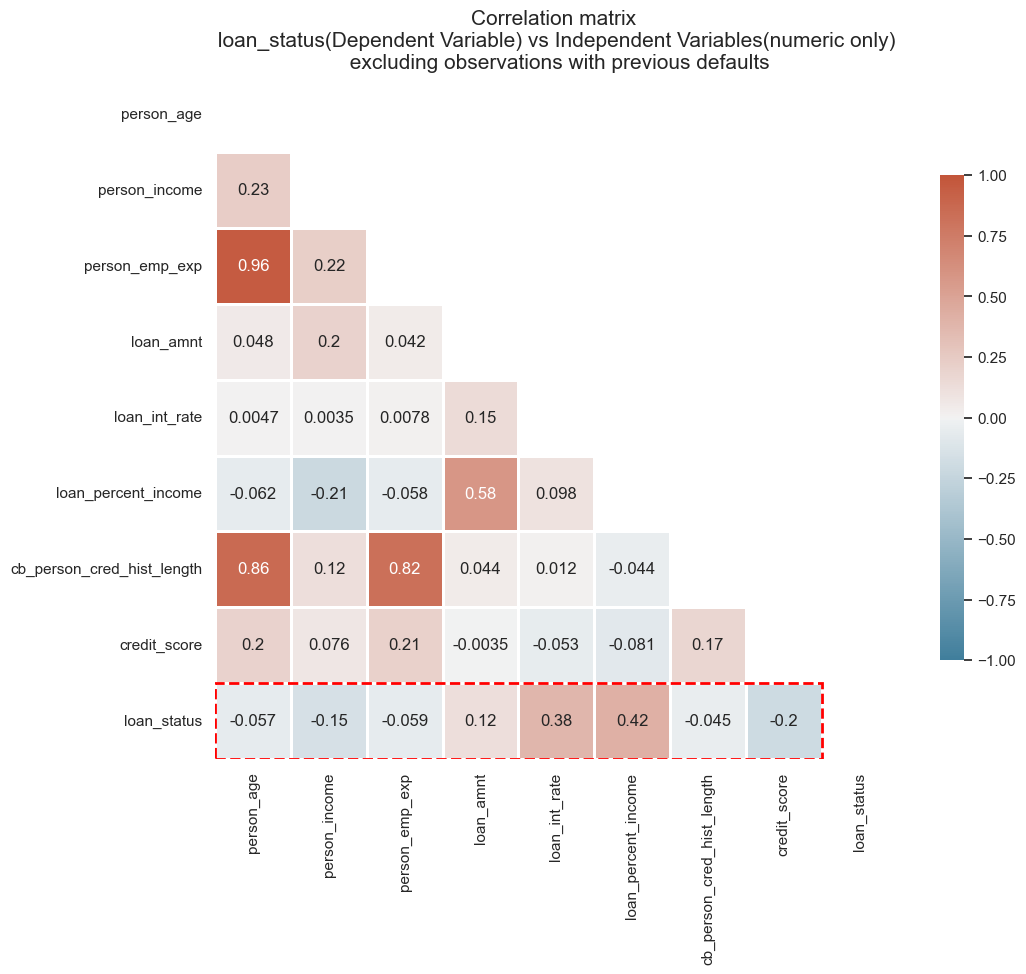

In [8]:
corr_matrix = df_subset.loc[:,num_col_names].corr()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap,vmax=1,vmin=-1,
            center=0,square=True,linewidths=0.75,linecolor='white',
            cbar_kws={'shrink':0.7},annot=True)

ax.add_patch(
    plt.Rectangle((0,9),width=8,height=-1,
                  rotation_point='xy',
                  edgecolor='red',lw=2,ls='--',fill=False)
)
plt.title('Correlation matrix \n loan_status(Dependent Variable) vs Independent Variables(numeric only) \n excluding observations with previous defaults',fontdict={'size':15})
plt.savefig(os.path.join(output_dir,'Correlation_Matrix_exclude_previous_defaults.png'))
np.save(os.path.join(output_dir,'Correlation_Matrix_exclude_previous_defaults.npy'),corr_matrix)
plt.show()


## Compare the change in correlation

Compare the original correlation of the independent variables(numeric only) to the loan_status

In [9]:
org_corr_matrix = np.load(os.path.join(output_dir,'Correlation_Matrix.npy'))
corr_matrix = np.load(os.path.join(output_dir,'Correlation_Matrix_exclude_previous_defaults.npy'))

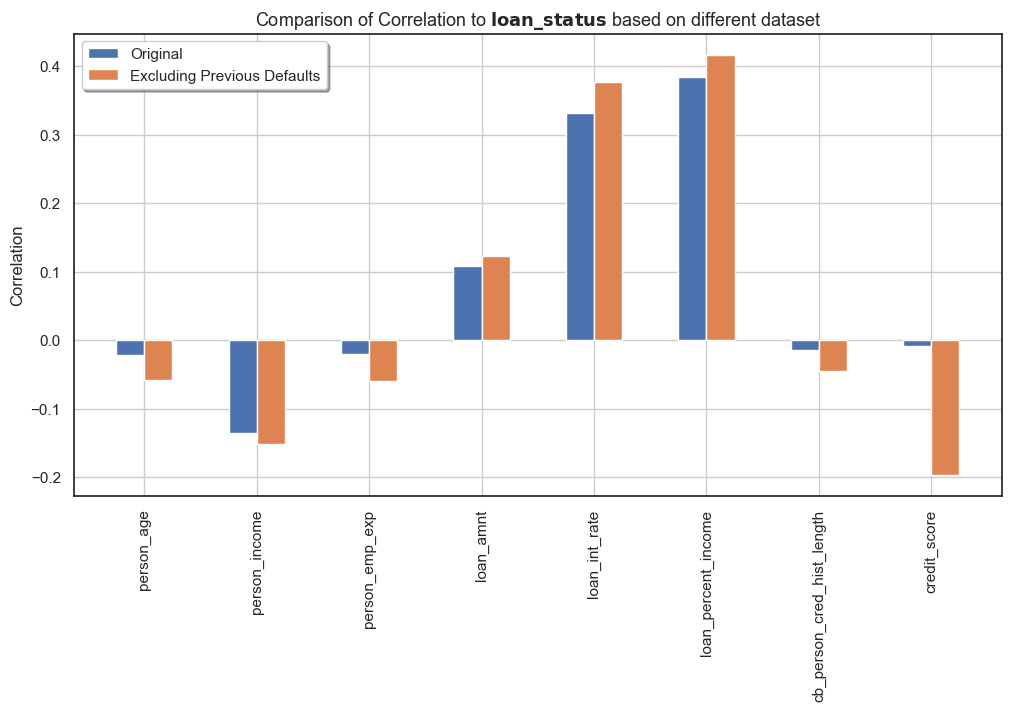

In [10]:
x_vars =num_col_names[:-1]
y_vars = {
    'Original':org_corr_matrix[-1,:-1],
    'Excluding Previous Defaults':corr_matrix[-1,:-1]
}

x = np.arange(len(x_vars))
fig, ax = plt.subplots(layout='constrained',figsize=(10,7))
width = 0.25
multiplier = 0.5
for label,num in y_vars.items():
    offset = width*multiplier
    bar_h = ax.bar(x + offset, num, width, label=label)
    multiplier += 1

ax.set_xticks(x + width, x_vars,rotation=90)
ax.set_ylabel('Correlation')
ax.legend(loc='upper left',shadow=True)
ax.grid(True)
plt.title(r'Comparison of Correlation to $\bf{loan \_ status}$ based on different dataset',fontsize=13)
plt.savefig(os.path.join(output_dir,'Compare_Correlation_values.png'))
plt.show()

No changes in the direction of the correlation values. Most notable change is for the variable **credit_score**. The correlation value went from close to 0 to -0.2.

One might think that this means that applicants, with no past defaults, having a higher credit score would lead to having your application denied. However, keep in mind that this is just the data exploration phase and the correlation value is still small.
This would be an interesting point for us to re-visit at the modeling phase.

## Explore the categorical data

Now that we have subset the data to ones that only have no past default status, lets see if anything changes with the rest of the categorical data.

In [12]:
from matplotlib.backends.backend_pdf import PdfPages


In [13]:
# columns for categorical data
cat_col_names

['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file']

<Figure size 640x480 with 0 Axes>

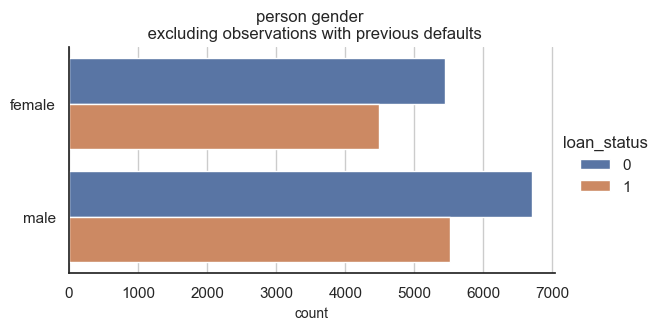

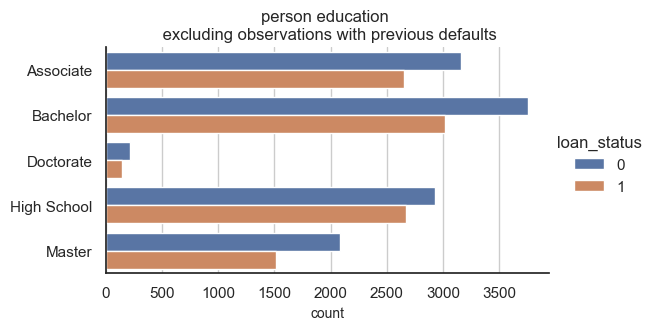

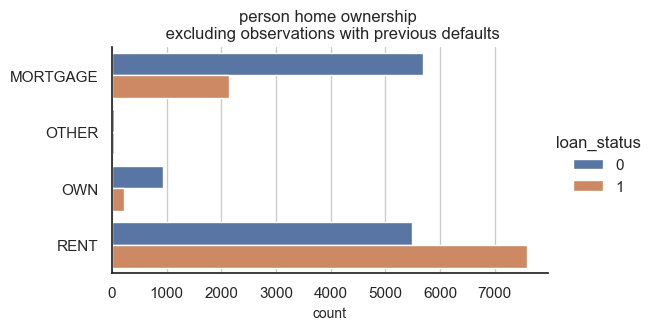

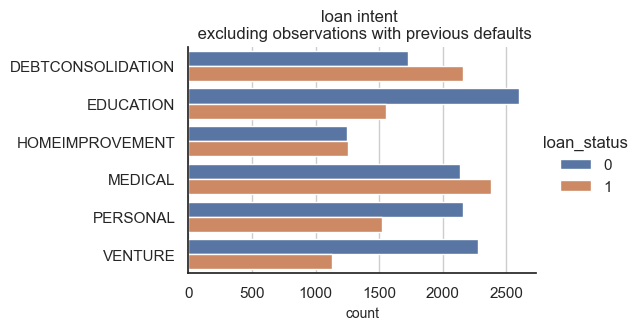

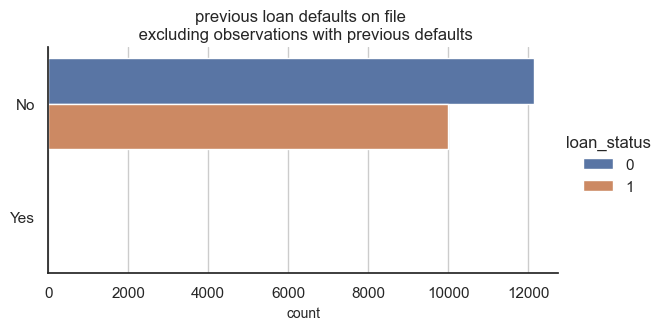

In [14]:
plt.rcParams.update({'font.size': 9, 'axes.labelsize': 10})
plot_pdf = os.path.join(output_dir,'Categorical_data_exclude_previous_defaults.pdf')

for i,var in zip(range(1,len(cat_col_names)+1),cat_col_names):
    fig = plt.figure(i)
    sns.catplot(data=df_subset.loc[:,[var,'loan_status']],
                y=var,hue='loan_status',
                kind='count',height=3,aspect=2)
    plt.ylabel(None)
    plt.title(var.replace('_',' ')+' \n excluding observations with previous defaults')
    plt.grid(axis='x')

p = PdfPages(plot_pdf)
fig_nums = plt.get_fignums()
fig_nums.remove(1)
figs = [plt.figure(n) for n in fig_nums]
for f in figs:
    f.savefig(p, format='pdf',bbox_inches='tight')
p.close()

### Conclusion

Compared to the full dataset, the loan status seems to be more evenly distributed amongst the categorical variables.

SignificanceResult(statistic=np.float64(-0.007647176334884976), pvalue=np.float64(0.10476273051043684))
SignificanceResult(statistic=np.float64(-0.1961731794975835), pvalue=np.float64(5.824551029908012e-191))


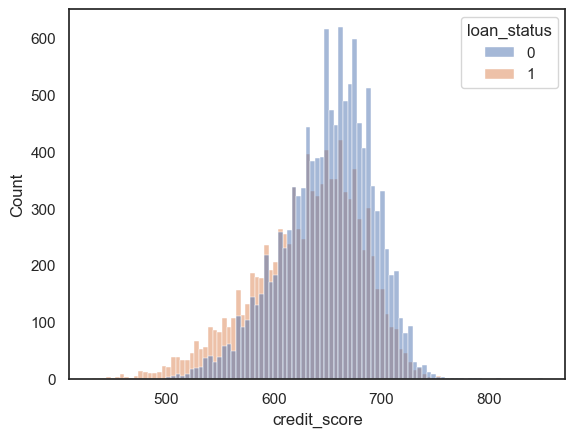

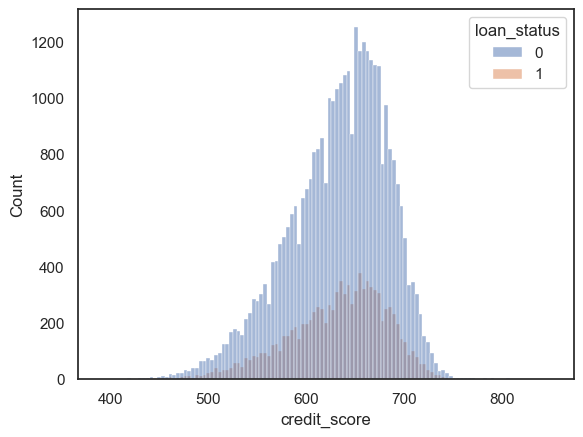

In [11]:
# quick check: use scipy.stats.pointbiserialr to see if anything changes
# quick visualization: histogram
from scipy import stats

print(stats.pointbiserialr(x=df['loan_status'].astype('bool'),y=df['credit_score']))

print(stats.pointbiserialr(x=df_subset['loan_status'].astype('bool'),y=df_subset['credit_score']))

sns.histplot(df_subset.loc[:,['credit_score','loan_status']],x='credit_score',hue='loan_status')
plt.show()

sns.histplot(df.loc[:,['credit_score','loan_status']],x='credit_score',hue='loan_status')
plt.show()